# Introduction

Here we describe our analysis of the wikipedia traffic data.

# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor

# Getting and Cleaning Data

We clean the data of NaN values by simply replacing each NaN value with the mean value of number of visits for each sample.

In [2]:
# Get the time series data.
data_df = pd.read_csv('train_2.csv')

print('data_df.shape = ', data_df.shape)
data_df.head()

data_df.shape =  (145063, 794)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [3]:
# Now fix NaN values in data_df.

means = data_df.drop('Page', axis = 1).mean(axis = 1)
means.fillna(0, inplace = True)

for column in data_df.columns:
    
    data_df[column].fillna(means, inplace = True)

data_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


# Page Features

## Breaking Up Page Data

Now we break up the Page data into the name of the page, the wikipedia project, the access, and the agent. We store these features in a separate dataframe, page_df.

In [4]:
# Let's get information from Page data.

urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in data_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

page_df = pd.DataFrame(data = pageInfo[0], columns = ['name'])

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    page_df[name] = infoCol

page_df.head()

,name,project,access,agent
0,2NE1,9,0,3
1,2PM,9,0,3
2,3C,9,0,3
3,4minute,9,0,3
4,52_Hz_I_Love_You,9,0,3


To get a rough idea of how features extracted from the name affect our predictions, for each sample we will make use of ratios of the mean target value of visits over the mean value of visits in the domain. Now, we will need to make predictions for 62 days worth of data, so we treat the last 62 days in our time series of visits as target data.

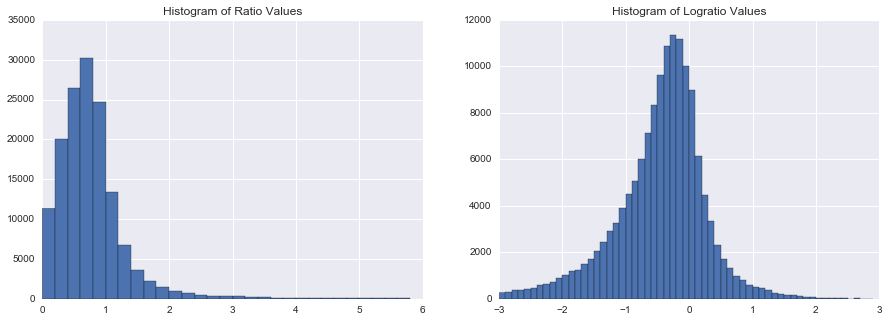

In [5]:
# Get the ratios of the means.

futureT = 62
epsilon = 1e-6

X_means = data_df.drop(['Page'], axis = 1).values[:, :-futureT].mean(axis = 1)
Y_means = data_df.drop(['Page'], axis = 1).values[:, -futureT:].mean(axis = 1)
ratios = Y_means / (epsilon + X_means)
page_df['ratios'] = ratios
page_df['logratios'] = np.log(epsilon + ratios)

doublefigsize = (15, 5)
plt.figure(figsize = doublefigsize)
plt.subplot('121')
page_df.ratios.hist(bins = np.arange(0, 6, 0.2))
plt.title('Histogram of Ratio Values')
plt.subplot('122')
page_df.logratios.hist(bins = np.arange(-3, 3, 0.1))
plt.title('Histogram of Logratio Values')
plt.show()

The histogram of ratio values is lop sided. We tried to fix it above by using the logarithm of the ratios. However, we see that the simple logarithm now has a tail on the left hand side. Let's fix this by putting an offest inside the logarithm. Then we will find a value of the offset such that the average square difference from the mean for those values above the mean matches that for the values below the mean.

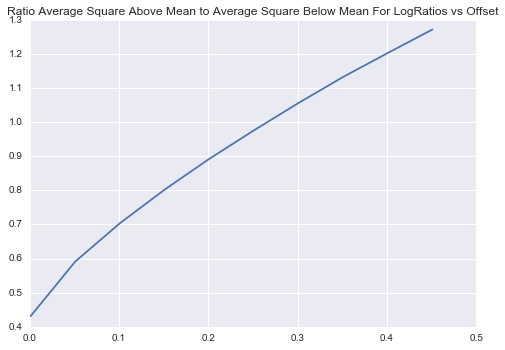

In [6]:
# Let's try to do a better job of centering ratio values.

search = np.arange(0.001, 0.5, 0.05)
above = []
below = []
for offset in search:
    logratios = np.log(offset + page_df.ratios)
    mean = logratios.mean()
    squares = (logratios - mean)**2
    above . append( squares[logratios > mean].mean())
    below . append( squares[logratios < mean].mean())
    
above = np.array(above)
below = np.array(below)
plt.plot(search, above / (epsilon + below))
plt.title('Ratio Average Square Above Mean to Average Square Below Mean For LogRatios vs Offset')
plt.show()

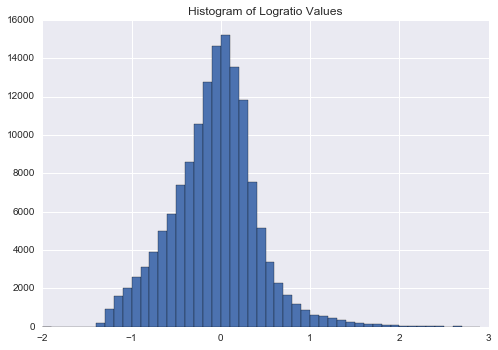

In [7]:
# Now do an offset of 0.25.

page_df['logratios'] = np.log(0.26 + ratios)
page_df.logratios.hist(bins = np.arange(-2, 3, 0.1))
plt.title('Histogram of Logratio Values')
plt.show()

## Name Features

Now we look at creating features from the names.

### Number of Words in Name

Let's count the number of words in each name by counting the number of appearances of the character '_'.

In [9]:
# Let's count number of words in name.

numWords = []

for name in page_df['name']:
    num = len(re.split(r'_', name))
    numWords.append(num)
        
numWords = np.array(numWords)

page_df['numWords'] = numWords

Let's look at a histogram of word counts and how mean of log ratios depends on word counts.

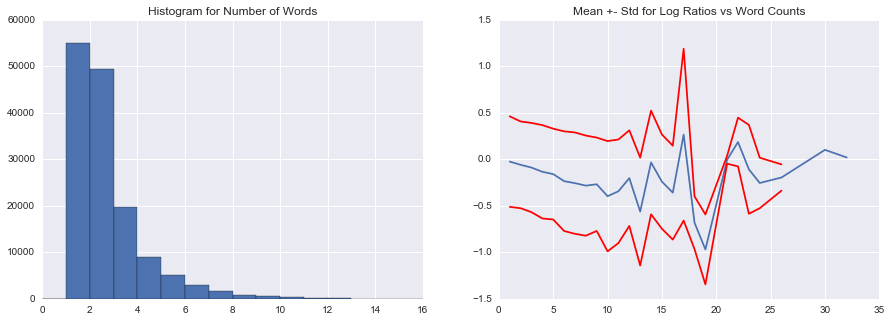

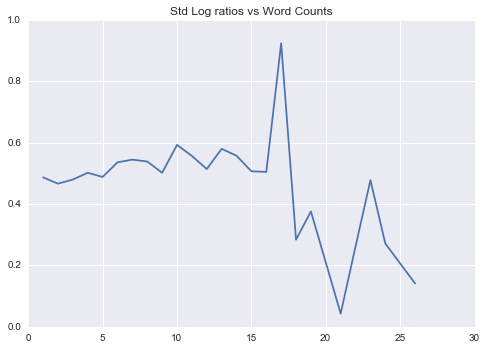

In [34]:
# Let's look at statistics for number of words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df['numWords'].hist(bins = np.arange(17))
plt.title('Histogram for Number of Words')

grouped_mean = page_df.groupby('numWords').mean()
grouped_std = page_df.groupby('numWords').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Word Counts')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Word Counts')
plt.show()

### Counts of Numbers in Name

Now let's look at counting the numbers that occur in each name.

In [40]:
# Let's look at number of Numbers.

numNums = []
for name in page_df['name']:
    num = len(re.split(r'\d+', name))
    numNums.append(num)
        
numNums = np.array(numNums)

page_df['numNums'] = numNums

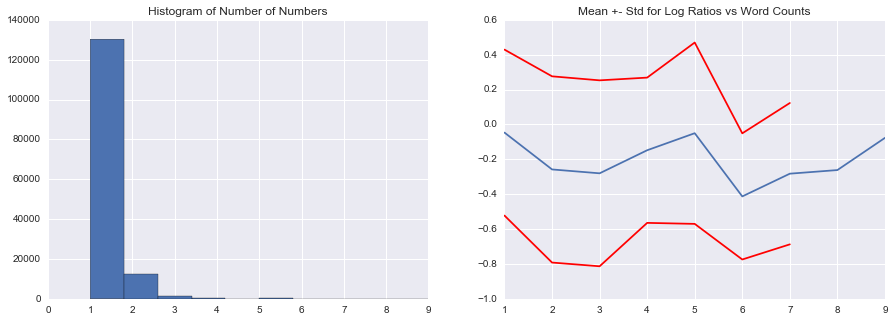

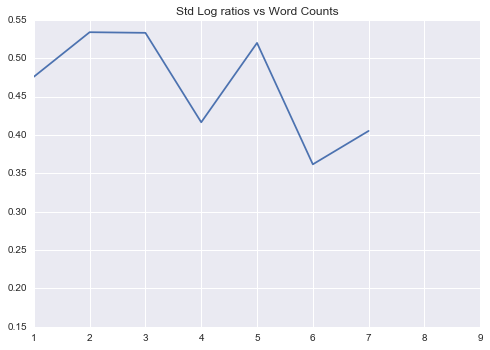

In [53]:
plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numNums.hist()
plt.title('Histogram of Number of Numbers')

grouped_mean = page_df.groupby('numNums').mean()
grouped_std = page_df.groupby('numNums').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Word Counts')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Word Counts')
plt.show()